In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def preprocessing():
    #reading the csv file
    df = pd.read_csv('CUACA MALANG 2000-2021.csv')
    #dropping unnecessary columns
    df = df.drop(['Tn','Tx','ff_x','ddd_x','ff_avg','ddd_car'], axis =1)
    #adjusting the date columns
    from datetime import date,timedelta
    datedata = []  
    start_yr, start_mo, start_dd = 2000,1,1
    end_yr, end_mo, end_dd = 2022,3,31
    start_date = date(start_yr, start_mo, start_dd) 
    end_date = date(end_yr, end_mo, end_dd) 
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        datedata.append(day)
    df = df.drop('Tanggal',axis =1)
    df['Date']  = datedata
    df['YR'] = [d.year for d in df['Date']]
    df['MO'] = [d.month for d in df['Date']]
    df['DD'] = [d.day for d in df['Date']]
    #filling null values in each column with interpolation values
    df['Tavg'] = df['Tavg'].interpolate()
    df['RH_avg'] = df['RH_avg'].interpolate()
    df['ss'] = df['ss'].interpolate()
    df['RR'] = df['RR'].fillna(0)
    import warnings
    warnings.filterwarnings('ignore')
    for index, value in enumerate(df['RR']):
        if value == 8888:
            df['RR'][index] = np.nan
        elif value == 9999:
            df['RR'][index] = np.nan
    df['RR'] = df['RR'].fillna(0)
    df = df[['Date', 'YR','MO','DD','Tavg','RH_avg','RR','ss']]
    return df

In [ ]:
df = preprocessing()
df

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss
0,2000-01-01,2000,1,1,24.1,69.0,82.0,5.4
1,2000-01-02,2000,1,2,22.9,77.0,0.0,1.2
2,2000-01-03,2000,1,3,23.8,78.0,14.0,4.1
3,2000-01-04,2000,1,4,24.2,77.0,10.0,1.3
4,2000-01-05,2000,1,5,23.4,78.0,0.0,3.6
...,...,...,...,...,...,...,...,...
8121,2022-03-27,2022,3,27,23.2,88.0,3.0,1.6
8122,2022-03-28,2022,3,28,23.8,82.0,4.7,0.7
8123,2022-03-29,2022,3,29,23.8,84.0,5.0,7.5
8124,2022-03-30,2022,3,30,24.8,79.0,3.4,4.7


In [ ]:
#function to visualize the data distribution
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    plt.hist(data[feature])
    plt.show()

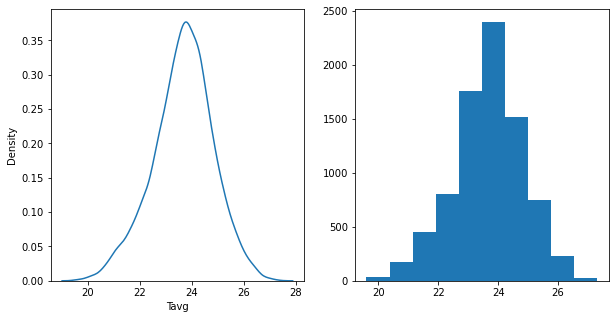

In [ ]:
normality(df,'Tavg')

In [ ]:
#Tavg looks to be normally distributed, so no transformation is required

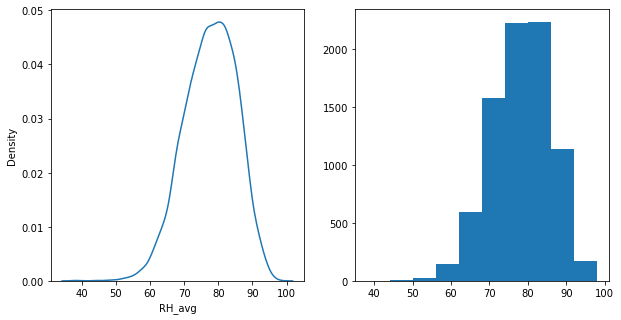

In [ ]:
normality(df,'RH_avg')

In [ ]:
#### The data for Humidity looks to be normal though a little left-skewed

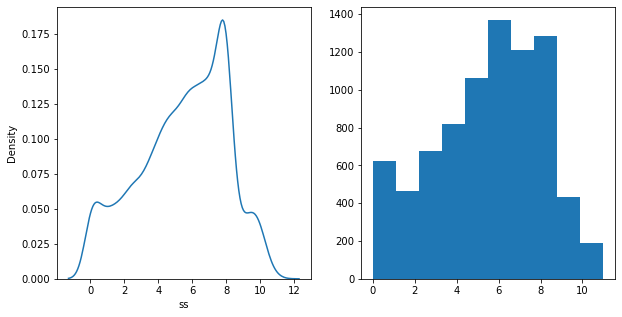

In [ ]:
normality(df,'ss')

In [ ]:
# data for ss does not seem to be normally distributed with a dominating peak for values of 8
# normalizing for ss uses box-cox transformation

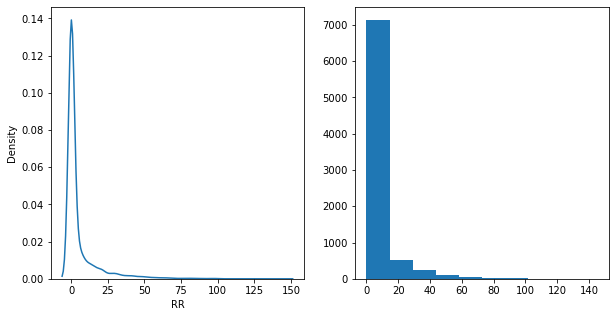

In [ ]:
normality(df,'RR')

In [ ]:
#### Precipitation data is heavily right-skewed, so a normalization is required.

In [ ]:
#creating another feature where if the value of RR > 0 label as '1', if RR = 0 label as '0'
condition = []
for index, value in enumerate(df['RR']):
    if value == 0:
        condition.append(0)
    else:
        condition.append(1)
df['Rainfall'] = condition

In [ ]:
# normalizing data using log(x+1) since the skew is mostly caused by the amount of 0 in the data
df['Transformed_RR'] = np.log(df['RR']+1)

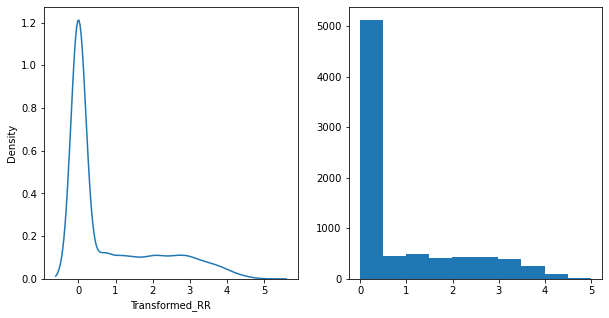

In [ ]:
normality(df,'Transformed_RR')

#### Normalizing the data with log(x+1) seems to alleviate some of the distances between the values, but the data with 0 values still dominates the cumulative distribution function.

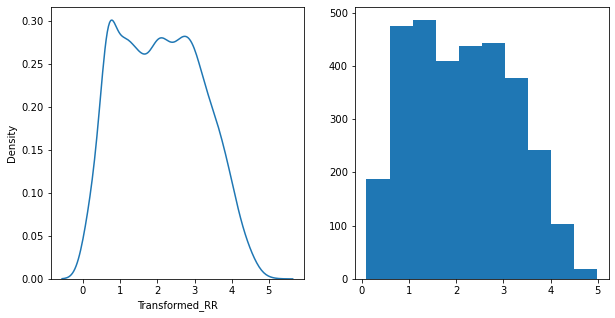

In [ ]:
df_rain = df[df['RR'] > 0]
normality(df_rain,'Transformed_RR')

#### Removing the data with 0 values shows that the distribution is normalized.

In [ ]:
def heatmap(df):
    df = df.drop(['Date','YR','MO','DD'],axis =1)
    correlations = df.corr()
    sns.heatmap(correlations, annot = True)

In [ ]:
#subsetting the dataset to only contain data from 2016 forward
#this is done to alleviate noise generated from previous periods which may be irrelevant for future predictions
df_2016 = df[df['YR'] >= 2016]
df_2016

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss,Rainfall,Transformed_RR
5844,2016-01-01,2016,1,1,25.1,82.0,11.8,6.7,1,2.549445
5845,2016-01-02,2016,1,2,25.1,81.0,3.5,6.3,1,1.504077
5846,2016-01-03,2016,1,3,25.6,82.0,22.8,5.9,1,3.169686
5847,2016-01-04,2016,1,4,24.8,88.0,11.5,5.7,1,2.525729
5848,2016-01-05,2016,1,5,25.6,79.0,0.0,6.2,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
8121,2022-03-27,2022,3,27,23.2,88.0,3.0,1.6,1,1.386294
8122,2022-03-28,2022,3,28,23.8,82.0,4.7,0.7,1,1.740466
8123,2022-03-29,2022,3,29,23.8,84.0,5.0,7.5,1,1.791759
8124,2022-03-30,2022,3,30,24.8,79.0,3.4,4.7,1,1.481605


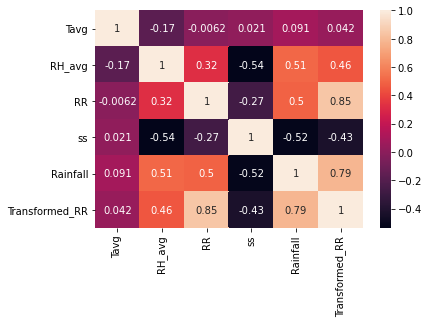

In [ ]:
heatmap(df_2016)

#### Heatmap shows that RR is highly correlated with ss (Sunlight Hrs) and RH_avg (Humidity)

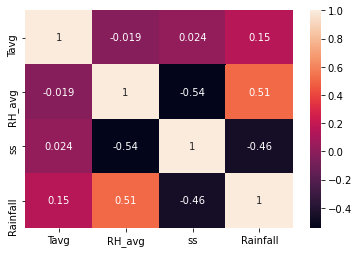

In [ ]:
heatmap(df.drop(['Transformed_RR','RR'], axis =1))

#### When the data with 0 precipitation are removed, the correlation levels for RH_avg and ss with RR drops significantly,  implying that RR value that is more than 0 has weak correlations to any features in the dataset. 

##### At this point predicting the actual RR values would be pointless as it does not have any relevant correlation to any features nor to its n-1 values. This research would rather predict the probability of the existence of precipitation using classifier algorithms.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def regression_test(ypred,ytest):
    MSE = mean_squared_error(ypred,ytest, squared = True)
    MAE = mean_absolute_error(ypred,ytest)
    MAPE = mape(ytest,ypred)
    return MSE,MAE,MAPE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# setting up data for predicting existence of precipitation using RH_avg and ss as the x
#x_lr_train = df_train[['RH_avg','ss']]
#y_lr_train = df_train[['Rainfall']]
#x_lr_test = df_test[['RH_avg','ss']]
#y_lr_test = df_test[['Rainfall']]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
x = df_2016[['RH_avg','ss']]
y = df_2016[['Rainfall']]
x_lr_train, x_lr_test, y_lr_train, y_lr_test = train_test_split(x, y,test_size = 0.1, random_state = 13,shuffle = True, stratify= y)
lr = LogisticRegression()
lr.fit(x_lr_train,y_lr_train)
y_lr_pred = lr.predict(x_lr_test)
print(classification_report(y_lr_pred,y_lr_test))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       121
           1       0.75      0.72      0.74       108

    accuracy                           0.76       229
   macro avg       0.76      0.75      0.75       229
weighted avg       0.76      0.76      0.76       229



In [ ]:
np.array(y_lr_test).flatten()

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [ ]:
print(classification_report(y_lr_pred,y_lr_test))
# Logistic Regression generates 82% accuracy for predicting the existence of precipitation

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1306
           1       0.67      0.74      0.70       726

    accuracy                           0.78      2032
   macro avg       0.76      0.77      0.76      2032
weighted avg       0.78      0.78      0.78      2032



In [ ]:
import pickle
pickle.dump(lr,open('RR_classifier','wb'))

In [ ]:
rain_prob = lr.predict_proba(df_2016[['RH_avg','ss']])
rain_bin = lr.predict(df[['RH_avg','ss']])
df_2016['Rain_probability'] = rain_prob[:,1]

In [ ]:
df_2016.head().to_clipboard()

In [ ]:
df_2016.to_csv('new weather with rain_prob')

In [ ]:
x_clf = df_2016[['YR','MO','DD']]
y_clf = df_2016[['Tavg','RH_avg','ss']]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_clf,y_clf)

In [ ]:
def preprocessingjan():
    df = pd.read_csv('Januari 2022.csv')
    df = df.drop(['ff_x','ddd_x','ff_avg','ddd_car','Tn','Tx'], axis =1)
    from datetime import date,timedelta
    datedata = []
    start_yr, start_mo, start_dd = 2022, 1, 1
    end_yr, end_mo, end_dd = 2022,1,31
    start_date = date(start_yr, start_mo, start_dd) 
    end_date = date(end_yr, end_mo, end_dd) 
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        datedata.append(day)
    df['Date'] = datedata
    df['YR'] = [d.year for d in df['Date']]
    df['MO'] = [d.month for d in df['Date']]
    df['DD'] = [d.day for d in df['Date']]
    df['Tavg'] = df['Tavg'].interpolate()
    df['RH_avg'] = df['RH_avg'].interpolate()
    df['ss'] = df['ss'].interpolate()
    df['RR'] = df['RR'].fillna(0)
    import warnings
    warnings.filterwarnings('ignore')
    for index, value in enumerate(df['RR']):
        if value == 8888:
            df['RR'][index] = 0
        elif value == 9999:
            df['RR'][index] = 0
    df = df[['Date', 'YR','MO','DD','Tavg','RH_avg','RR','ss']]
    return df

In [ ]:
df_jan = preprocessingjan()

In [ ]:
RR_jan = np.array(df_jan['RR']).flatten()
condition_jan = [1 if i > 0 else 0 for i in RR_jan]
df_jan['Rainfall'] = condition_jan

In [ ]:
from datetime import date,timedelta
def date_sequence(start_yr,start_mo,start_dd,end_yr,end_mo,end_dd):
    datedata = []
    start_date = date(start_yr, start_mo, start_dd) 
    end_date = date(end_yr, end_mo, end_dd) 
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        datedata.append(day)
    datedata = pd.to_datetime(datedata)
    new = pd.DataFrame()
    new['YR'] = [d.year for d in datedata]
    new['MO'] = [d.month for d in datedata]
    new['DD'] = [d.day for d in datedata]
    return new

In [ ]:
preddate = date_sequence(2022,1,1,2022,1,31)

In [ ]:
pred = rf.predict(preddate)
preddate['Tavg']= pred[:,0]
preddate['RH_avg']= pred[:,1]
preddate['ss']= pred[:,2]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def regression_test(ypred,ytest):
    MSE = mean_squared_error(ypred,ytest, squared = True)
    MAE = mean_absolute_error(ypred,ytest)
    return MSE,MAE

In [ ]:
def metrics_dataframe(df):
    columns = df_jan.drop(['Date','YR','MO','DD','RR','Rainfall'],axis =1).columns.tolist()
    mse_list = []
    mae_list = []
    mape_list = []
    evaluation = pd.DataFrame(columns=['Features','MSE','MAE'])
    evaluation['Features'] = columns
    for i in columns:
        MSE,MAE = regression_test(df[i],df_jan[i])
        mse_list.append(MSE)
        mae_list.append(MAE)
    evaluation['MSE'] = mse_list
    evaluation['MAE'] = mae_list
    return evaluation

In [ ]:
test = metrics_dataframe(preddate)
test

,Features,MSE,MAE
0,Tavg,1.068835,0.874000
1,RH_avg,49.334184,5.944839
2,ss,8.273559,2.288097


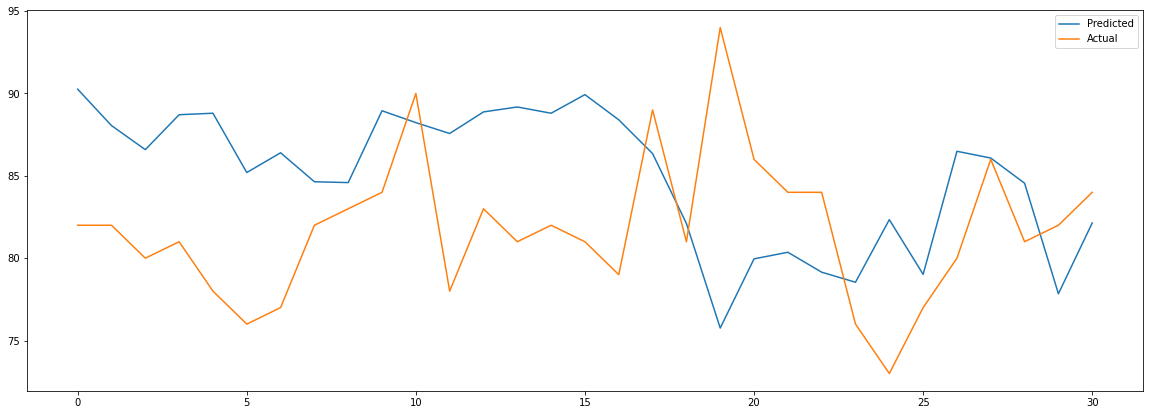

In [ ]:
plt.figure(figsize = (20,7))
plt.plot(preddate['RH_avg'], label = 'Predicted')
plt.plot(df_jan['RH_avg'], label = 'Actual')
plt.legend()

In [ ]:
df = pd.concat([df,df_jan])
df

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss,Rainfall
0,2000-01-01,2000,1,1,24.1,69.0,82.0,5.4,1
1,2000-01-02,2000,1,2,22.9,77.0,0.0,1.2,0
2,2000-01-03,2000,1,3,23.8,78.0,14.0,4.1,1
3,2000-01-04,2000,1,4,24.2,77.0,10.0,1.3,1
4,2000-01-05,2000,1,5,23.4,78.0,0.0,3.6,0
...,...,...,...,...,...,...,...,...,...
26,2022-01-27,2022,1,27,25.0,80.0,2.8,3.5,1
27,2022-01-28,2022,1,28,24.0,86.0,1.8,4.6,1
28,2022-01-29,2022,1,29,24.5,81.0,0.0,2.8,0
29,2022-01-30,2022,1,30,24.6,82.0,1.5,1.8,1


In [ ]:
df['Tavg_prev']=df.Tavg.shift(1)
df['RH_avg_prev'] = df.RH_avg.shift(1)
df['ss_prev'] = df.ss.shift(1)
df

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss,Rainfall,Tavg_prev,RH_avg_prev,ss_prev
0,2000-01-01,2000,1,1,24.1,69.0,82.0,5.4,1,NaN,NaN,NaN
1,2000-01-02,2000,1,2,22.9,77.0,0.0,1.2,0,24.1,69.0,5.4
2,2000-01-03,2000,1,3,23.8,78.0,14.0,4.1,1,22.9,77.0,1.2
3,2000-01-04,2000,1,4,24.2,77.0,10.0,1.3,1,23.8,78.0,4.1
4,2000-01-05,2000,1,5,23.4,78.0,0.0,3.6,0,24.2,77.0,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...
8121,2022-03-27,2022,3,27,23.2,88.0,3.0,1.6,1,24.3,82.0,1.5
8122,2022-03-28,2022,3,28,23.8,82.0,4.7,0.7,1,23.2,88.0,1.6
8123,2022-03-29,2022,3,29,23.8,84.0,5.0,7.5,1,23.8,82.0,0.7
8124,2022-03-30,2022,3,30,24.8,79.0,3.4,4.7,1,23.8,84.0,7.5


In [ ]:
df_new_2016 = df[df['YR'] >= 2016]

In [ ]:
df_train = df_new_2016[df_new_2016['YR']<= 2021]
df_test = df_new_2016[df_new_2016['YR']> 2021]
x_train = df_train[['YR','MO','DD','Tavg_prev','RH_avg_prev','ss_prev']]
y_train = df_train[['Tavg','RH_avg','ss']]
x_test = df_test[['YR','MO','DD','Tavg_prev','RH_avg_prev','ss_prev']]
y_test = df_test[['Tavg','RH_avg','ss']]

In [ ]:
#x_lnr = df_new_2016[['YR','MO','DD','Tavg_prev','RH_avg_prev','ss_prev']]
#y_lnr = df_new_2016[['Tavg','RH_avg','ss']]
#x_lnr_train,x_lnr_test,y_lnr_train,y_lnr_test = train_test_split(x_lnr,y_lnr,test_size = 0.1, random_state = 13, shuffle = False)

In [ ]:
rf_ar = RandomForestRegressor()
rf_ar.fit(x_train,y_train)
pred_ar = rf_ar.predict(x_test)

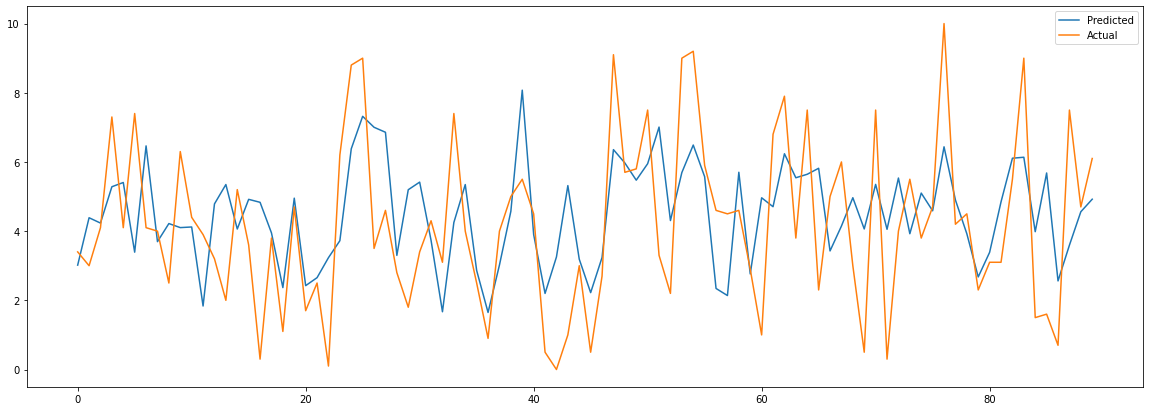

In [ ]:
n = 2
plt.figure(figsize = (20,7))
plt.plot(pred_ar[:,n],label = 'Predicted')
plt.plot(np.array(y_test)[:,n],label = 'Actual')
plt.legend()

In [ ]:
regression_test(pred_ar[:,n],np.array(y_test)[:,n])

(4.597533717970524, 1.7712976190476193)

In [ ]:
x_rain_pred = pred_ar[:,1:]
y_rain_actual = df_test['Rainfall']
y_rain_pred = lr.predict(x_rain_pred)


print(classification_report(y_rain_pred,y_rain_actual))

              precision    recall  f1-score   support

           0       0.30      0.50      0.37        12
           1       0.91      0.82      0.86        78

    accuracy                           0.78        90
   macro avg       0.61      0.66      0.62        90
weighted avg       0.83      0.78      0.80        90



In [ ]:
training_pred = pd.DataFrame()
training_pred['Tavg'] = pred_ar[:,0]
training_pred['RH_avg'] = pred_ar[:,1]
training_pred['ss'] = pred_ar[:,2]
training_pred.to_clipboard()

In [ ]:
y_lnr_test.to_clipboard()

In [ ]:
huh = np.array(date_sequence(2022,1,1,2022,3,30))
steps = len(huh)
p = pred_ar[-1]
    for i in steps:
        to_predict = np.append(huh[steps],p)
prediction = rf_ar.predict(huh.reshape(-1,len(huh)))
prediction

array([[23.95 , 85.68 ,  3.784]])

In [ ]:
x_lnr_test['ss']

7816    5.668000
7817    5.650000
7818    8.473214
7819    6.053000
7820    5.815000
          ...   
8031    5.158000
8032    4.806000
8033    5.898000
8034    4.866000
8035    3.642000
Name: ss, Length: 220, dtype: float64

In [ ]:
x_rainfall = df_new_2016[['RH_avg','ss']]
y_rainfall = df_new_2016['Rainfall']
x_rfl_train,x_rfl_test,y_rfl_train,y_rfl_test = train_test_split(x_rainfall,y_rainfall,test_size = 0.1, random_state = 13, shuffle = False)

In [ ]:
y_rfl_test

7816    0
7817    0
7818    0
7819    1
7820    0
       ..
8031    0
8032    0
8033    1
8034    1
8035    0
Name: Rainfall, Length: 220, dtype: int64

In [ ]:
y_rain_pred = svm.predict(x_rfl_test)
print(classification_report(y_rain_pred,y_rfl_test))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       135
           1       0.61      0.66      0.63        85

    accuracy                           0.70       220
   macro avg       0.69      0.70      0.69       220
weighted avg       0.71      0.70      0.71       220



In [ ]:
x_lnr = df_2016[['RH_avg','ss']]
y_lnr = df_2016[['Transformed_RR']]
x_lnr_train,x_lnr_test,y_lnr_train,y_lnr_test = train_test_split(x_lnr,y_lnr,test_size = 0.1, random_state = 13, shuffle = True)

In [ ]:
from sklearn.linear_model import LinearRegression
lnr = LinearRegression()
lnr.fit(x_lnr_train,y_lnr_train)

LinearRegression()

In [ ]:
y_lnr_pred = lnr.predict(x_lnr_test)
MSE,MAE,MAPE = regression_test(y_lnr_pred,y_lnr_test)
print('MSE=',MSE,'\n')
print('MAE=',MAE,'\n')
print('MAPE=',MAPE,'\n')

MSE= 1.3142984104316902 

MAE= 0.9087315537541366 

MAPE= inf 



In [ ]:
df_new = pd.DataFrame()
df_new['Predictions'] = y_lnr_pred.flatten()
df_new['Actual'] = np.array(y_lnr_test).flatten()
df_new.to_clipboard()